# Image reconstruction from spectrometer data

This notebook contains Python code for reading saved spectrometer data, preprocessing of that data and finally reconstruction algorithm.

Jouni Huopana 12.12.2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import serial
from serial.tools import list_ports
from scipy.io import savemat
import glob

In [2]:
files = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/solid_6_NC_00/*.out')

nmeas = 30
all_data = np.zeros((nmeas,288))
for fname in files:
    temp = np.loadtxt(fname, delimiter=",")
    all_data += 1/10*temp

In [3]:
# Spectrometer wavelengths are interpolated from a 4th degree polynomial 

p_f = np.array([3.077488719E2,2.679347131,-6.896962135E-4,-1.162714405E-5,2.387336221E-8,-1.432225987E-11])
x_data = np.arange(288)
p = np.poly1d(np.flip(p_f))
wavelengths = p(np.arange(288))


# Blur function to blur image data

def blur(a):
    kernel = np.array([[1.0,2.0,1.0], [2.0,4.0,2.0], [1.0,2.0,1.0]])
    kernel = kernel / np.sum(kernel)
    arraylist = []
    for y in range(3):
        temparray = np.copy(a)
        temparray = np.roll(temparray, y - 1, axis=0)
        for x in range(3):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x - 1, axis=1)*kernel[y,x]
            arraylist.append(temparray_X)

    arraylist = np.array(arraylist)
    arraylist_sum = np.sum(arraylist, axis=0)
    return arraylist_sum

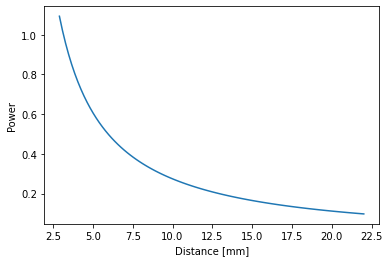

In [4]:
# Power from point light source

P = 1        # Power
mu_a = 0.01  # 
mu_s = 1.4   #

r = np.linspace(0.29,2.2,100)
D = (1/3)/(mu_a+mu_s)            # Background diffusion constant
delta = (D/mu_a)**0.5            # Optical penetration depth

phi = np.zeros(r.shape)

for i in range(r.shape[0]):
    phi[i] = P*np.exp(-r[i]/delta)/(4*np.pi*D*r[i])
    
plt.plot(r*10,phi)
plt.ylabel('Power')
plt.xlabel('Distance [mm]')
plt.show()

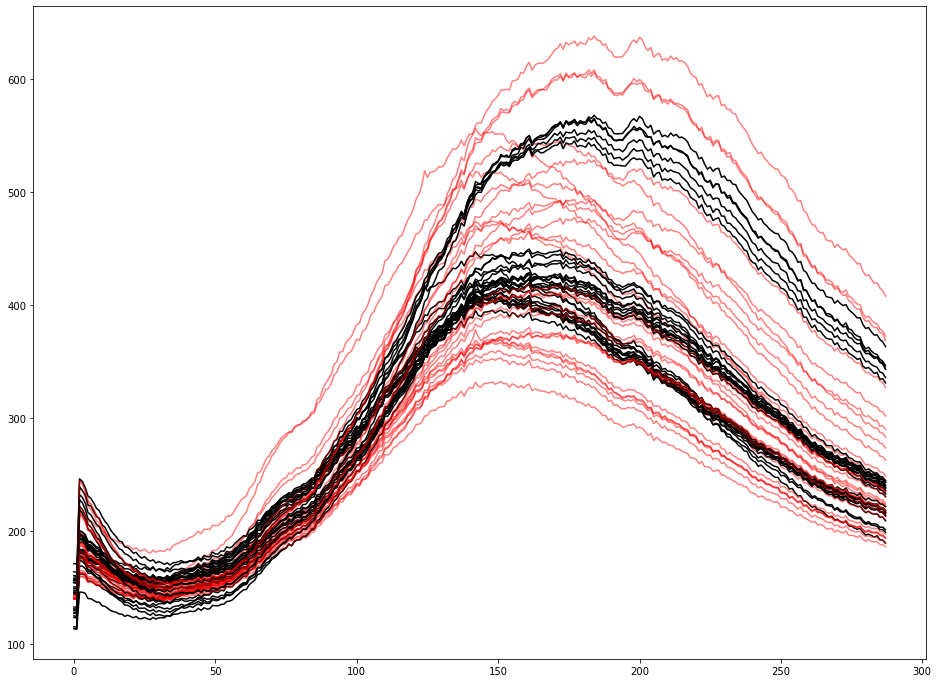

[0.80364136 0.87660017 0.92925759 1.11283496 1.10930734 0.8121155
 0.94770348 0.89032473 1.06507908 1.14337223 0.89306433 0.89396146
 1.14185009 1.11440192 1.19103351 1.00014523 1.03660701 1.1128242
 1.11730149 1.12681428 1.01622677 1.03686611 1.04952463 1.02521959
 1.10248451 0.90708509 0.82253822 0.9315429  1.06918606 1.10122927]


In [5]:
# Defining calibration vector using similar paths and symmetry 

# Symmetry in 1 and 5 paths
n1 = np.hstack(((np.arange(6)*5+0),(np.arange(6)*5+4)))
# Symmetry in 2 and 4 paths
n2 = np.hstack(((np.arange(6)*5+1),(np.arange(6)*5+3)))
mean_scale = np.zeros(30)

plt.figure(figsize=(16,12))

# Caluclating mean for symmetry postions n1
pos_data = all_data[n1,:]
mean = np.mean(pos_data)
mean_fix = np.zeros(12)

for i in range(12):
    mean_fix[i] = np.mean(pos_data[i,:])

for i in range(12):
    plt.plot(pos_data[i,:],'r',alpha=0.5)
    plt.plot(pos_data[i,:]*mean/mean_fix[i],'k')

mean_scale[n1] = mean/mean_fix

# Caluclating mean for symmetry postions n2
pos_data = all_data[n2,:]
mean = np.mean(pos_data)
mean_fix = np.zeros(12)

for i in range(12):
    mean_fix[i] = np.mean(pos_data[i,:])

for i in range(12):
    plt.plot(pos_data[i,:],'r',alpha=0.5)
    plt.plot(pos_data[i,:]*mean/mean_fix[i],'k')

mean_scale[n2] = mean/mean_fix

# Caluclating mean for the last position
j=2
pos_data = all_data[(np.arange(6)*5+j),:]
mean = np.mean(pos_data)
mean_fix = np.zeros(6)

for i in range(6):
    mean_fix[i] = np.mean(pos_data[i,:])

for i in range(6):
    plt.plot(pos_data[i,:],'r',alpha=0.5)
    plt.plot(pos_data[i,:]*mean/mean_fix[i],'k')

mean_scale[(np.arange(6)*5+j)] = mean/mean_fix


plt.show()

print(mean_scale)

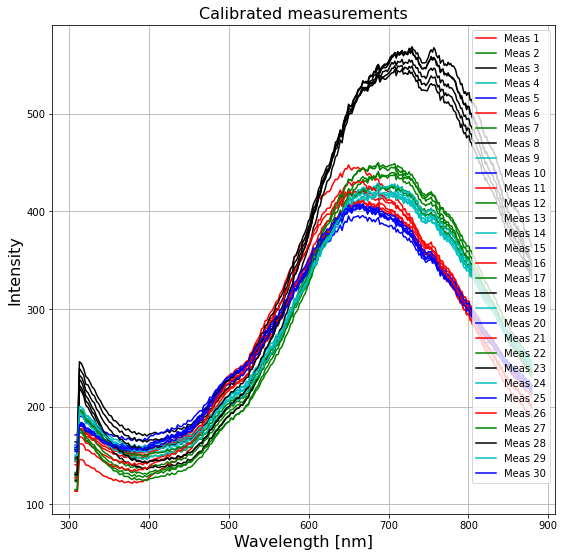

[0.80364136 0.87660017 0.92925759 1.11283496 1.10930734 0.8121155
 0.94770348 0.89032473 1.06507908 1.14337223 0.89306433 0.89396146
 1.14185009 1.11440192 1.19103351 1.00014523 1.03660701 1.1128242
 1.11730149 1.12681428 1.01622677 1.03686611 1.04952463 1.02521959
 1.10248451 0.90708509 0.82253822 0.9315429  1.06918606 1.10122927]


In [6]:
# Reading and calibrating data

files = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/solid_6_NC_00/*.out')

nmeas = 30
all_data = np.zeros((nmeas,288))
for fname in files:
    temp = np.loadtxt(fname, delimiter=",")
    all_data += 1/10*temp

li = ['b','r','g','k','c']
names = []
for i in range(nmeas):
    names.append("Meas "+str(i+1))
    all_data[i,:] = all_data[i,:]*mean_scale[i]
    

plt.figure(figsize=(9,9))
idx=0
idl=0
for i in range(nmeas):
    x = all_data[idx,:]

    idl = (idx + 1) % len(li)

    idx += 1
    plt.plot(wavelengths,x,li[idl])

    
plt.title("Calibrated measurements",fontsize=16)
plt.grid()
plt.legend(names,loc=1)
plt.ylabel("Intensity",fontsize=16)
plt.xlabel("Wavelength [nm]",fontsize=16)
plt.show()

print(mean_scale)

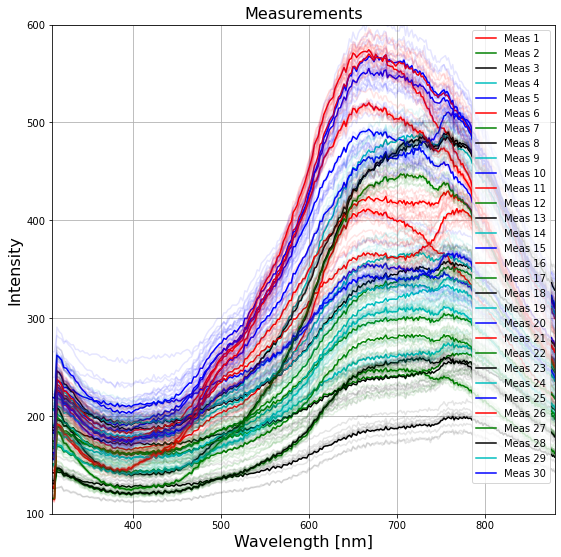

In [7]:
# Reading and calibrating data with plotting all the data 

files = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/solid_6_green_left_red_right/*.out')

nmeas = 30
all_data = np.zeros((nmeas,288))
for fname in files:
    temp = np.loadtxt(fname, delimiter=",")
    all_data += 1/10*temp

plt.figure(figsize=(9,9))

idx=0
idl=0
for i in range(nmeas):
    x = all_data[idx,:]*mean_scale[idx]

    idl = (idx + 1) % len(li)

    idx += 1
    plt.plot(wavelengths,x,li[idl])

for fname in files:
    idx=0
    idl=0
    temp = np.loadtxt(fname, delimiter=",")
    for i in range(nmeas):
        x = temp[idx,:]*mean_scale[idx]

        idl = (idx + 1) % len(li)

        idx += 1
        plt.plot(wavelengths,x,li[idl],alpha=0.1)
        
        
plt.title("Measurements",fontsize=16)
plt.grid()
plt.legend(names,loc=1)
plt.ylabel("Intensity",fontsize=16)
plt.xlabel("Wavelength [nm]",fontsize=16)
plt.axis([308, 879, 100, 600])
plt.show()

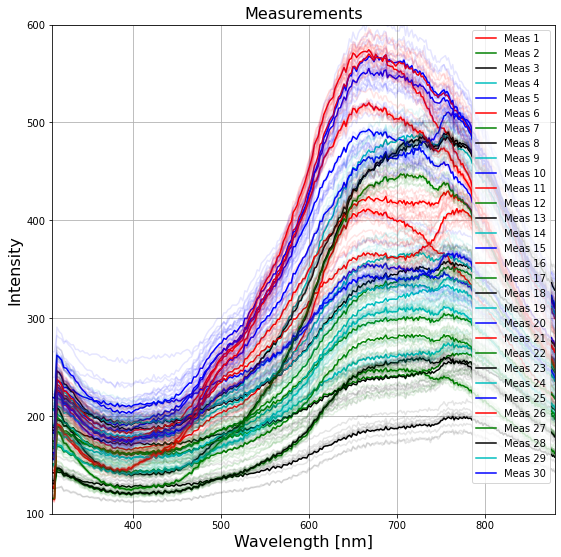

In [23]:
# Reading and calibrating data with plotting all the data 

files = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/solid_6_green_left_red_right/*.out')

nmeas = 30
all_data = np.zeros((nmeas,288))
for fname in files:
    temp = np.loadtxt(fname, delimiter=",")
    all_data += 1/10*temp

plt.figure(figsize=(9,9))

idx=0
idl=0

for i in range(nmeas):
    x = all_data[idx,:]*mean_scale[idx]

    idl = (idx + 1) % len(li)

    idx += 1
    plt.plot(wavelengths,x,li[idl])

for fname in files:
    idx=0
    idl=0
    temp = np.loadtxt(fname, delimiter=",")
    for i in range(nmeas):
        x = temp[idx,:]*mean_scale[idx]

        idl = (idx + 1) % len(li)

        idx += 1
        plt.plot(wavelengths,x,li[idl],alpha=0.1)
        
        
plt.title("Measurements",fontsize=16)
plt.grid()
plt.legend(names,loc=1)
plt.ylabel("Intensity",fontsize=16)
plt.xlabel("Wavelength [nm]",fontsize=16)
plt.axis([308, 879, 100, 600])
plt.show()

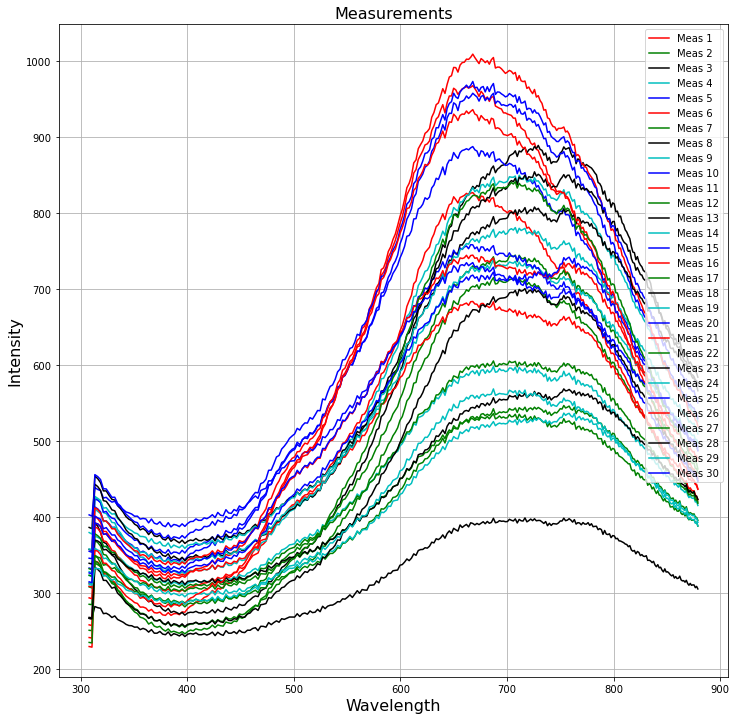

In [9]:
# Reading and calibrating data with plotting all the data 

files = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/*.out')

nmeas = 30
all_data = np.zeros((nmeas,288))
for fname in files:
    temp = np.loadtxt(fname, delimiter=",")
    all_data += 1/10*temp

li = ['b','r','g','k','c']
names = []
for i in range(nmeas):
    names.append("Meas "+str(i+1))
    all_data[i,:] = all_data[i,:]*mean_scale[i]
    

plt.figure(figsize=(12,12))
idx=0
idl=0
for i in range(nmeas):
    x = all_data[idx,:]

    idl = (idx + 1) % len(li)

    idx += 1
    plt.plot(wavelengths,x,li[idl])

    
plt.title("Measurements",fontsize=16)
plt.grid()
plt.legend(names,loc=1)
plt.ylabel("Intensity",fontsize=16)
plt.xlabel("Wavelength",fontsize=16)
plt.show()

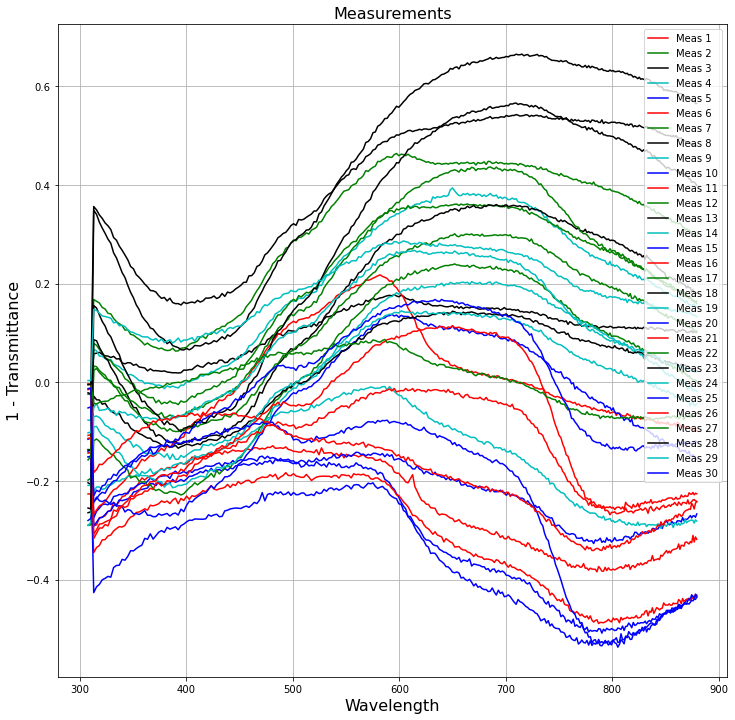

In [10]:
# Reading and calibrating data and calculating transmittance from two data sets

def load_meas(fnames,nmeas,mean_scale):
    files = fnames
    all_data = np.zeros((nmeas,288))
    for fname in files:
        temp = np.loadtxt(fname, delimiter=",")
        all_data += 1/10*temp

    for i in range(nmeas):
        all_data[i,:] = all_data[i,:]*mean_scale[i]

    return all_data

# Reference data
fnames = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/solid_6_NC_00/*.out')
ref_data = load_meas(fnames,nmeas,mean_scale)

# Measurement data
fnames = glob.glob('/Users/jouni.huopana/Documents/CSE/Thesis/Temp/solid_6_green_left_red_right/*.out')
meas_data = load_meas(fnames,nmeas,mean_scale)

temp_data = np.zeros(ref_data.shape)

for i in range(nmeas):
    temp_data[i,:] = (ref_data[i,:] - meas_data[i,:]) / ref_data[i,:]

plt.figure(figsize=(12,12))
idx=0
idl=0
for i in range(nmeas):
    x = temp_data[idx,:]

    idl = (idx + 1) % len(li)

    idx += 1
    plt.plot(wavelengths,x,li[idl])

    
plt.title("Measurements",fontsize=16)
plt.grid()
plt.legend(names,loc=1)

plt.ylabel("1 - Transmittance",fontsize=16)
plt.xlabel("Wavelength",fontsize=16)
plt.show()

all_data = temp_data

[215 213 216 211 218 221 217 214 220 210]
780.8041354594561


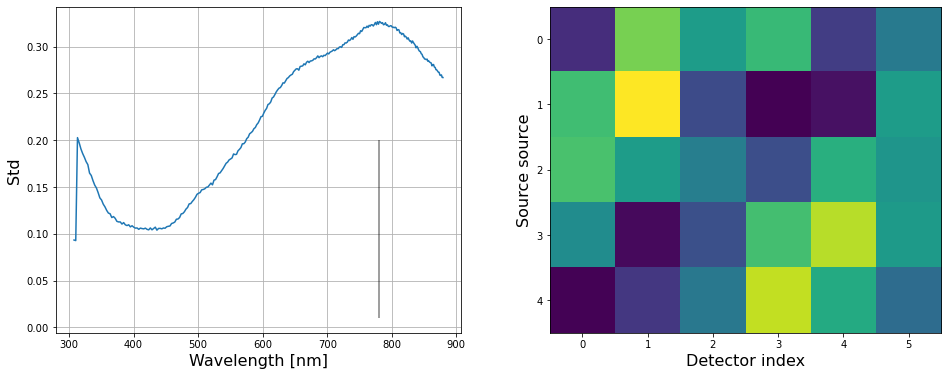

In [11]:
# Selecting the wavelength with maximum deviation

fig, axs = plt.subplots(1,2, figsize=(16,6))

stdi = np.std(all_data,axis=0)
    
axs[0].plot(wavelengths,stdi)
axs[0].grid()
axs[0].set_xlabel('Wavelength [nm]',fontsize=16)
axs[0].set_ylabel('Std',fontsize=16)

most=np.argsort(stdi)[-10:][::-1]

sinogram = all_data[:,most[0]]

axs[0].vlines(wavelengths[most[0]],0.01,0.2,'k',alpha=0.5)

print(most)
print(wavelengths[most[0]])

axs[1].imshow(np.reshape(sinogram,(5,6)))
axs[1].set_xlabel('Detector index',fontsize=16)
axs[1].set_ylabel('Source source',fontsize=16)

plt.show()

In [12]:
#Measurement sequence indexes
seq = np.zeros((nmeas,2))

idx = 0
for i in range(6):
    dd = np.roll(np.arange(6), -i)
    for j in range(6):
        if i==dd[j]:
            pass
        else:
            seq[idx] = np.array([i,dd[j]])
            idx += 1 

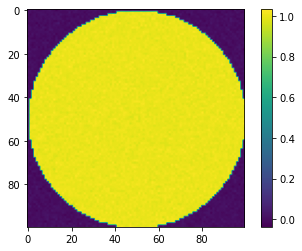

In [13]:
# Measurement image template
dx = 100
dy = 100

image = np.zeros((dx,dy))

x0 = dx/2
y0 = dy/2

for i in range(dx):
    for j in range(dy):
        dist = np.sqrt((y0-i)**2+(x0-j)**2)
        if dist < dx/2:
            image[i,j] = 1

noise = np.random.normal(0, 0.01, image.shape)  
            
image = image+noise
plt.imshow(image)
plt.colorbar()
plt.show()

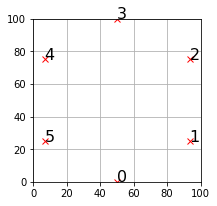

In [14]:
n_det = 6
r = 50

# Measurement detector/source locations
theta = (np.arange(n_det)-1.5)/n_det*2*np.pi
x_loc = (r*np.cos(theta) + r)
y_loc = (r*np.sin(theta) + r)

plt.figure(figsize=(3,3))
plt.plot(x_loc,y_loc,'rx')

for i in range(6):
    plt.text(x_loc[i],y_loc[i],str(i),fontsize=16)

plt.axis([0,2*r,0,2*r])
plt.grid()
plt.show()

In [15]:
# Defining Matrix A

m = int(sinogram.shape[0])
n = int(dx*dy)

A = np.zeros((m,n))

idx = 0

empt = np.ones(dx*dy)

for m in range(nmeas):
    d_x = int(x_loc[int(seq[m,0])])
    d_y = int(y_loc[int(seq[m,0])])

    s_x = int(x_loc[int(seq[m,1])])
    s_y = int(y_loc[int(seq[m,1])])
    
    s_x = (s_x - dx/2)*1.1 + dx/2
    s_y = (s_y - dy/2)*1.1 + dy/2

    i_map = np.zeros(image.shape)

    for i in range(dx):
        for j in range(dy):
            dist = np.sqrt((s_y-i)**2+(s_x-j)**2)
            dist_l = np.abs(np.cos(theta[int(seq[m,1])])*(i-s_y)-np.sin(theta[int(seq[m,1])])*(j-s_x))
            dist_c = np.sqrt((dy/2-i)**2+(dx/2-j)**2)

            i_map[i,j] = 1/np.exp(-(dist*2.2/100)/delta)/(4*np.pi*D*(dist*2.2/100))*1.0 + 5*1/(100-dist_l)/100 
            if dist_c > dx/2:
                i_map[i,j] = 0

    #plt.imshow(i_map)
    #plt.gca().invert_yaxis()
    #plt.colorbar()
    #plt.show()
    
    i_map = i_map/i_map.max()
    stencil = np.zeros(image.shape)

    ray_x = np.linspace(s_x,d_x,50)
    ray_y = np.linspace(s_y,d_y,50)


    idt = 0
    for i in range(dx):
        for j in range(dy):
            x1 = s_x
            y1 = s_y
            x2 = d_x
            y2 = d_y
            y0 = j
            x0 = i
            dist = np.abs((x2-x1)*(y1-y0)-(x1-x0)*(y2-y1))/np.sqrt((x2-x1)**2+(y2-y1)**2)
            
            l_lim = 110
            if dist<l_lim:
                stencil[j,i] = i_map[j,i]*(l_lim-dist)/l_lim
            
            dist_c = np.sqrt((dy/2-i)**2+(dx/2-j)**2)
            if dist_c > dx/2:
                stencil[j,i] = 0
                empt[idt] = 0
            idt += 1

    # Save the stencil images
    plt.figure(figsize=(9,9))
    plt.imshow(stencil)
    plt.quiver(d_x,d_y,-np.cos(theta[int(seq[m,0])]),-np.sin(theta[int(seq[m,0])]),scale=3,color="white")
    plt.title('Measurement '+str(m))
    plt.axis([0,99,0,99])
    plt.savefig('images/Stencil_'+str(m)+'.png')
    plt.close()

    A[idx,:] = stencil.flatten()
    idx += 1

print("Done")

Done


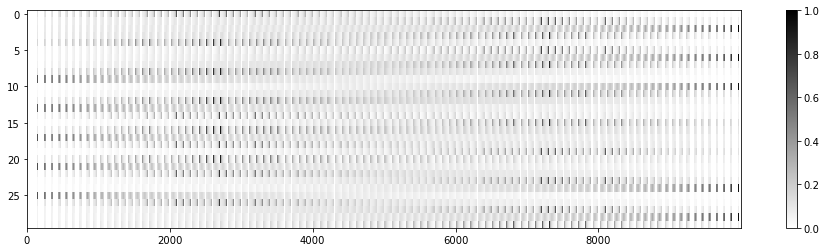

In [17]:
plt.figure(figsize=(16,4))
plt.imshow(A,interpolation='nearest', aspect='auto', cmap='binary')
plt.colorbar()
plt.show()

In [18]:
#Measurement sequence indexes
seq = np.zeros((nmeas,2))

idx = 0
for i in range(6):
    dd = np.roll(np.arange(6), -i)
    for j in range(6):
        if i==dd[j]:
            pass
        else:
            seq[idx] = np.array([i,dd[j]])
            idx += 1 

In [19]:
b = sinogram.flatten()

x0 = np.random.normal(0, 0.001, image.shape).flatten()  

# INPUT   : A - MxN-matrix in sparse form
#           y - (M,1)-vector containing the data
#           x0- (N,1)-vector, the initial guess
#           w - relaxation parameter, 0<w<2
#           n - integer, the number of desired iteration rounds
# OUTPUT  : x - (N,1)-vector, the iterated reconstruction
#-----------------------------------------------------------------------------
# Based on 29/2/96 Erkki Somersalo Matlab example
#-----------------------------------------------------------------------------

def ART(A,y,x0,w,n):
    j = 0
    x = x0
    M = len(y)
    k = 0
    k1=0
    while j < n:
        for ell in range(M):
            a = A[ell,:] 
            aa = np.matmul(a,a.T)

            if aa != 0:
                x = x + w/aa*(y[ell] - np.matmul(a,x))*a.T
                
                # This is used to save intermitten steps as images
                if k1==50 and False:
                    recon_1 = x.reshape(100,100)
                    minv = np.unravel_index(recon_1.argmax(), recon_1.shape)
                    
                    mse = np.round(((best - np.matmul(A,x))**2).mean(),5)
                    
                    r_temp = 49.5
                    phi_temp = np.linspace(0,2*np.pi,100)
                    x_temp = r_temp*np.sin(phi_temp) + r_temp 
                    y_temp = r_temp*np.cos(phi_temp) + r_temp
                    
                    plt.figure(figsize=(9,9))
                    plt.imshow(blur(recon_1), vmin = 0)
                    plt.plot(minv[1],minv[0],'rx')
                    
                    plt.plot(x_temp,y_temp,'w',linewidth=4)
                    plt.axis([0,99,0,99])
                    
                    plt.title('Mofified ART reconstruction, MSE='+ str(mse)[0:5])
                    plt.savefig('images/ART_'+str(k)+'.png')
                    k1 = 0
                    k += 1
                    plt.close()
                k1 += 1
        j = j+1
        
        # Modifications 
        #x = abs(x) # values represent absorbtion
        x = x*empt # values outside the region do not cotribute
        x = blur(np.reshape(x,(100,100))).flatten() # values do not have sudden changes over the medium
    
    return x

#CGLS
def CGLS(A,b,x0,N):
    r0 = b - np.matmul(A,x0)
    s0 = p0 = np.matmul(A.T,r0)
    gamma0 = np.matmul(s0,s0)

    for i in range(N):
        q0 = np.matmul(A,p0)
        alpha0 = gamma0/np.matmul(q0,q0)
        x1 = x0 + alpha0*p0
        r1 = r0 - alpha0*q0

        s1 = np.matmul(A.T,r1)
        gamma1 = np.matmul(s1,s1)
        beta0 = gamma1/gamma0
        p1 = s1 + beta0*p0

        p0 = p1.copy()
        gamma0 = gamma1.copy()
        s0 = s1.copy()
        r0 = r1.copy()
        #x0 = x1 
        x0 = x1.copy()
        x0 = x0*empt
        x0 = blur(np.reshape(x0,(100,100))).flatten()
            
    return x0
    
x_1 = ART(A,b,x0,0.5,200)

x_2 = CGLS(A,b,x0,1)
k = 0
k1=0
for i in range(200):
    x_2 = CGLS(A,b,x_2,1)
    
    #Only for plotting
    if k1==10 and False:
        recon_1 = x_2.reshape(100,100)
        minv = np.unravel_index(recon_1.argmax(), recon_1.shape)

        mse = np.round(((best - np.matmul(A,x_2))**2).mean(),5)

        r_temp = 49.5
        phi_temp = np.linspace(0,2*np.pi,100)
        x_temp = r_temp*np.sin(phi_temp) + r_temp 
        y_temp = r_temp*np.cos(phi_temp) + r_temp

        plt.figure(figsize=(9,9))
        plt.imshow(blur(recon_1), vmin = 0)
        plt.plot(minv[1],minv[0],'rx')

        plt.plot(x_temp,y_temp,'w',linewidth=4)
        plt.axis([0,99,0,99])

        plt.title('Mofified CGLS reconstruction, MSE='+ str(mse)[0:5])
        plt.savefig('images/CGLS_'+str(k)+'.png')
        k1 = 0
        k += 1
        plt.close()
    k1 += 1
    
    

print('Done')

Done


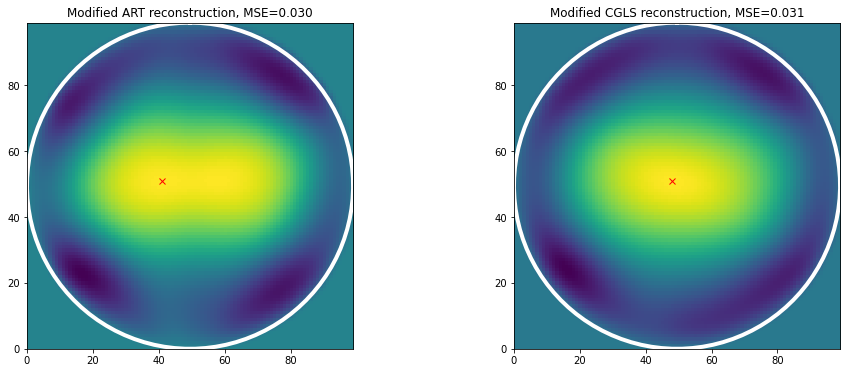

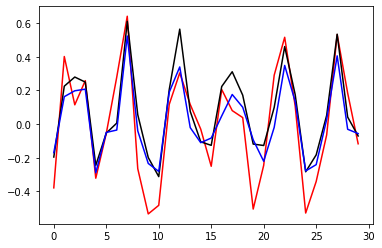

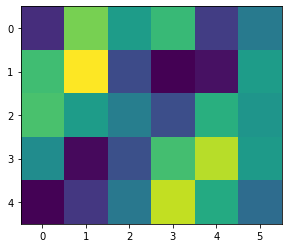

In [22]:
#Plotting the results for ART and CGLS

fig, axs = plt.subplots(1,2, figsize=(16,6))

r_temp = 49.5
phi_temp = np.linspace(0,2*np.pi,100)
x_temp = r_temp*np.sin(phi_temp) + r_temp 
y_temp = r_temp*np.cos(phi_temp) + r_temp

recon_1 = x_1.reshape(dx,dy)
minv = np.unravel_index(recon_1.argmax(), recon_1.shape)

mse1 = np.round(((b - np.matmul(A,x_1))**2).mean(),5)

axs[0].imshow((recon_1))
axs[0].set_title('Modified ART reconstruction, MSE='+str(mse1)[0:5])
axs[0].plot(minv[1],minv[0],'rx')
axs[0].plot(x_temp,y_temp,'w',linewidth=4)
axs[0].axis([0,99,0,99])

recon_2 = x_2.reshape(dx,dy)
minv = np.unravel_index(recon_2.argmax(), recon_2.shape)

mse2 = np.round(((b - np.matmul(A,x_2))**2).mean(),5)

axs[1].imshow((recon_2))
axs[1].set_title('Modified CGLS reconstruction, MSE='+str(mse2)[0:5])
axs[1].plot(minv[1],minv[0],'rx')
axs[1].plot(x_temp,y_temp,'w',linewidth=4)
axs[1].axis([0,99,0,99])

plt.show()


plt.plot(b,'r')
plt.plot(np.matmul(A,x_1),'k')
plt.plot(np.matmul(A,x_2),'b')
plt.show()


plt.imshow(np.reshape(b,(5,6)))
plt.show()

In [ ]:
stop here

Following scripts are just for creating images

In [ ]:
plt.rcParams['savefig.dpi'] = 300

for j in range(nmeas):
    plt.figure(figsize=(9,9))
    idx=0
    idl=0
    for i in range(j+1):
        x = temp_data[idx,:]

        idl = (idx + 1) % len(li)

        idx += 1
        plt.plot(wavelengths,x,li[idl])

    plt.title("Measurements",fontsize=16)
    plt.grid()
    plt.legend(names,loc=1)

    plt.ylabel("1 - Transmittance",fontsize=16)
    plt.xlabel("Wavelength",fontsize=16)
    plt.savefig('images/Meas_'+str(j)+'.png')
    plt.close()



In [ ]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

def concat_n_images(image_path_list):
    """
    Combines N color images from a list of image paths.
    """
    output = None
    for i, img_path in enumerate(image_path_list):
        img = plt.imread(img_path)[:,:,:3]
        if i==0:
            output = img
        else:
            output = concat_images(output, img)
    return output

In [ ]:
art_idx = np.round(np.power(np.arange(30), 1.418))

for i in range(nmeas):
    images = ["images/Stencil_"+str(i)+".png", "images/Meas_"+str(i)+".png", "images/ART_"+str(int(art_idx[i]))+".png"]
    output = concat_n_images(images)

    plt.figure(figsize=(9*3,9))
    plt.imshow(output)
    plt.axis('off')
    plt.savefig('images/Result_'+str(i)+'.png')
    plt.close()

In [ ]:
n_wl = 12
id_wl = np.linspace(0,287,13).astype('int')

fig, axs = plt.subplots(3,4, figsize=(16,12))
ax = axs.ravel()

for i in range(n_wl):
    #print(id_wl[i+1],str(wavelengths[id_wl[i+1]])[0:5])
    b = all_data[:,id_wl[i+1]].flatten()
    x_0 = np.random.normal(0, 0.001, image.shape).flatten()  
    
    #Loop for reconstructions
    x_2 = CGLS(A,b,x_0,1)
    #x_2 = ART(A,b,x_0,0.5,200)
    for j in range(200):
        x_2 = CGLS(A,b,x_2,1)
        
    recon_2 = x_2.reshape(dx,dy)
    minv = np.unravel_index(recon_2.argmax(), recon_2.shape)
    mse2 = np.round(((best - np.matmul(A,x_2))**2).mean(),5)
    ax[i].imshow((recon_2))
    
    ax[i].set_title('CGLS, '+str(wavelengths[id_wl[i+1]])[0:5]+' nm, MSE='+str(mse2)[0:5])
    ax[i].plot(minv[1],minv[0],'rx')
    ax[i].plot(x_temp,y_temp,'w',linewidth=4)
    ax[i].axis([0,99,0,99])

plt.show()